## Title :
Vanishing Gradients

## Description :
The goal of this exercise is to understand the vanishing gradient problem in training RNNs and using various methods to improve training.

In order to do this exercise, we will use the IMDB movie review dataset to perform sentiment analysis.

Your final comparison for the trace plot may look something like this:

<img src="../fig/fig.png" style="width: 500px;">

## Instructions:
- Read the IMDB dataset from the helper code given.
- Take a quick look at your training inputs and labels.
- Pad the values to a fix number `max_words` in-order to have sequences of the same size.
- First post pad the inputs with `padding='post'` i.e sequences smaller than `max_words` will be followed by zero padding.
- Build, compile and fit a Vanilla RNN and evaluate it on the test set.
- Now refit the model, but this time post pad the inputs with `padding='pre'`
- Again evaluate the model performance on the test set.
- Finally, rebuild a model with the Gated Recurrent Unit and fit and evaluate on the training and test set respectively.
- Compare the performance of all three models similar to the table above.

## Hints:

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences" target="_blank">tensorflow.keras.preprocessing.sequence.pad_sequences()</a> Pad the sequences to same length - pre/post.

## Vanilla RNNs

We will use Vanilla Recurrent Neural Networks to perform sentiment analysis in `tensorflow.keras` using imdb movie reviews dataset.
The dataset is a subset consisting of 10,000 reviews in the training and test set each. [see here for more info](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

In [1]:
# Import required libraries
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,GRU
import pickle
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pprint import pprint

2023-08-07 22:20:15.075606: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 22:20:15.102817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 22:20:15.103239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 22:20:15.782084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
# We fix a vocabulary size of 5000
# Use the code below to call a small subset of the imdb dataset
# We keep the vocabulary size fixed because it was used to curate the sub-dataset
vocabulary_size = 5000
# with open('imdb_mini.pkl','rb') as f:
    # X_train, y_train, X_test, y_test = pickle.load(f)


#### Inspect a sample review and its label

In [60]:
import pandas as pd
data = pd.read_csv("IMDB Dataset.csv")

import re

def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    # \S+: matches one or more non-whitespace characters
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    # matches any character that is not (^ negation) an uppercase letter (A-Z), a lowercase letter (a-z), or a digit (0-9).
    x = re.sub('\s+', ' ', x)
    # \s: matches any whitespace character, such as spaces, tabs, and newline characters.
    return x.lower().strip()

data['review'] = data['review'].apply(lambda x: process(x))

import nltk
nltk.download('stopwords')
nltk.download('punkt')

sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

data['review'] = data['review'].apply(lambda x: sw_remove(x))

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2, random_state=109)

X_train = train["review"]
y_train = 1 * (train["sentiment"] == "positive")
X_test = test["review"]
y_test = 1*(test["sentiment"] == "positive")

from keras.preprocessing.text import Tokenizer

dict_size = 5000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(data['review'])

train_rev_tokens = tokenizer.texts_to_sequences(X_train)
test_rev_tokens = tokenizer.texts_to_sequences(X_test)
seq_lengths =  np.array([len(sequence) for sequence in train_rev_tokens])

[nltk_data] Downloading package stopwords to /home/ting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# Run the code below to see the first tokenized review and the label
print('---review---')
print(train_rev_tokens[0])
print('---label---')
print(y_train[0])

---review---
[1423, 2, 486, 172, 356, 151, 536, 791, 10, 1, 868, 21, 171, 2238, 1221, 23, 345, 1651, 522, 76, 2129, 19, 2547, 4956, 2110, 3009, 2238, 1221, 609, 153, 3009, 86, 1237, 261, 2385, 3466, 607, 1221, 1221, 86, 96, 653, 587, 2123, 340, 71, 1218, 342, 2396, 297, 1651, 162, 291, 4939, 192, 2397, 254, 2123, 92, 4913, 3437, 162, 356, 144, 252, 576, 10, 948, 112, 8, 34, 40, 587, 148, 1610, 963, 74, 10, 849, 1251, 2507, 1640, 141, 16, 638, 133, 1, 1542, 655, 377, 17, 77, 919, 486, 349]
---label---
1


In [15]:
# You can get the word2id mapping by
# using the imdb.get_word_index() function

word2id = imdb.get_word_index()
# We need to adjust the mapping by 3 because of tensorflow.keras preprocessing
# more here: https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
word2id = {k:(v+3) for k,v in word2id.items()}
word2id["<PAD>"] = 0
word2id["<START>"] = 1
word2id["<UNK>"] = 2
word2id["<UNUSED>"] = 3

# Reversing the key,value pair will give the id2word
id2word = {i: word for word, i in word2id.items()}
pprint('---review with words---')
pprint(" ".join([id2word[i] for i in train_rev_tokens[0]]))
pprint('---label---')
pprint(y_train[0]);

# NOT match X_train[0], perhaps because train_rev_tokens and word2id used different index

'---review with words---'
('filming <UNK> humor same classic though thinking elements br <START> stage '
 'but few parker audiences on either struggle late much laughter with magical '
 'willis types served parker audiences hell years served first involving '
 'although category luckily save audiences audiences first way change '
 'including bear completely were images 3 fare play struggle new year sink '
 "fact north hard bear don't craven increasingly new classic should sure "
 'extremely br creepy being to by like including those rented e than br indeed '
 'aspect accidentally favourite such was across here <START> seven middle '
 'remember as been laughs humor men')
'---label---'
1


In [13]:
X_train[0]

'one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack stree

Maximum review length and minimum review length

### ⏸ The `<UNK>` tag is reserved for?


#### A. Special characters
#### B. Out of vocabulary words
#### C. Start of sentence
#### D. End of sentence

In [5]:
### edTest(test_chow1) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer1 = 'B'

In [16]:
# For training we need our sequences to be of fixed length, but the reviews
# are of different sizes
print(f'Maximum review length: {len(max([i for i in train_rev_tokens]+[i for i in test_rev_tokens], key=len))}')
# key = len
print(f'Minimum review length: {len(min([i for i in train_rev_tokens]+[i for i in test_rev_tokens], key=len))}')

Maximum review length: 916
Minimum review length: 2


In [17]:
# We also create two indices for short and long reviews
# we will use this later
idx_short = [i for i,val in enumerate(train_rev_tokens) if len(val)<100]
idx_long = [i for i,val in enumerate(train_rev_tokens) if len(val)>500]

### Pad sequences

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews. We can accomplish this using the pad_sequences() function in `tensorflow.keras`. For now, set max_words to 500.

### ⏸ If we use *post-padding* on a sequence, the new sequence is"


#### A. "Padded with zeros before the start of original sequence"
#### B. "Padded with zeros after the end of the original sequence"
#### C. "Padded with ones before the start of original sequence"
#### D. "Padded with ones after the end of the original sequence"

In [8]:
### edTest(test_chow2) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer2 = 'B'

In [66]:
# We will clip large reviews and pad smaller reviews to 500 words
max_words = 500
# We can pad the smaller sequences with 0s before, or after.
# This choice can severely affect network performance
# In the first case we, will pad after the sequence 
# Please utilize sequence.pad_sequences()
postpad_X_train = sequence.pad_sequences(train_rev_tokens, maxlen= max_words, padding="post")
postpad_X_test = sequence.pad_sequences(test_rev_tokens, maxlen = max_words, padding="post")

### RNN model for sentiment analysis

We build the model architecture in the code cell below. We have imported some layers from `tensorflow.keras` that you might need but feel free to use any other layers / transformations you like.

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).

In [19]:
def model_maker(summary=True,gru=False):
# One layer RNN model with 32 rnn cells
    embedding_size=32
    model=Sequential()
    model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
    
    # We can specify if we want the GRU cell or the vanilla RNN cell
    if gru:
        model.add(GRU(32))
    else:
        model.add(SimpleRNN(32))
        # tf.keras.layers.SimpleRNN(units,

    model.add(Dense(1, activation='sigmoid'))
    if summary:
        print(model.summary())
        
    # model compile step
    model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])    
    return model

## Trace Plot analysis
We expect the postpadded model to perform train slowly because of vanishing gradients.
Let us investigate the cause by training two models,
- One with shorter reviews (that were post padded) using `idx_short`
- The other with longer reviews (that were truncated) using `idx_long`

In [21]:
# We build two new models with vanilla RNNs
model_short = model_maker(summary=False)
model_long = model_maker(summary=False)

2023-08-10 13:08:47.444999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [68]:
# First we train `model_short` with short reviews
# set epochs to 10

X_short = postpad_X_train[idx_short]
y_short = y_train.reset_index(drop = True)[idx_short]
epochs = 10
history_short = model_short.fit(X_short, y_short, epochs=epochs,batch_size=640,verbose=0);

2023-08-10 14:29:15.735714: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53988000 exceeds 10% of free system memory.
2023-08-10 14:29:16.481000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2023-08-10 14:29:16.491545: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2023-08-10 14:29:16.592699: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.
2023-08-10 14:29:16.602814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40960000 exceeds 10% of free system memory.


In [69]:
# Then we train `model_long` with short reviews

X_long = postpad_X_train[idx_long]
y_long = y_train.reset_index(drop = True)[idx_long]
history_long = model_long.fit(X_long,y_long, epochs=epochs,batch_size=640,verbose=0);

In [70]:
### edTest(test_chow2_1) ###
X_short_shape, y_short_shape = X_short.shape, y_short.shape
X_long_shape, y_long_shape = X_long.shape, y_long.shape
print(X_short_shape, y_short_shape,X_long_shape, y_long_shape)

(26994, 500) (26994,) (19, 500) (19,)


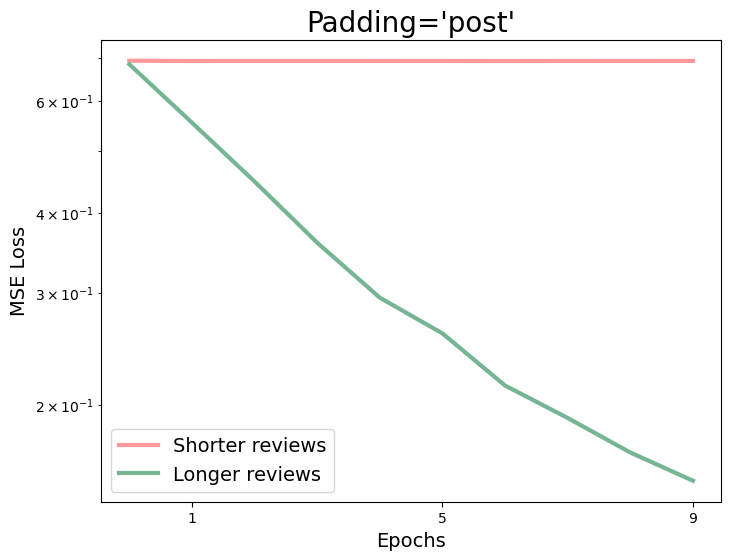

In [71]:
# Helper function to plot the data
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Padding='post'",fontsize=20)
plt.semilogy(history_short.history['loss'], label='Shorter reviews', color='#FF9A98', linewidth=3)
plt.semilogy(history_long.history['loss'],  label='Longer reviews', color='#75B594', linewidth=3)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs',fontsize=14)
plt.xticks(range(1,epochs,4))
plt.ylabel('MSE Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Pre-padding sequences

As we can see, the vanishing gradient problem is real and can severely affect the training of our network. The short review network negligibly trains, whereas the longer review model trains very well.
To counter this, we will now *pre-pad* the shorter sequences.

In [72]:
# We can pre-pad by using `sequence.pad_sequences` with `padding='pre'`
max_words = 500
prepad_X_train = sequence.pad_sequences(train_rev_tokens, maxlen=max_words, padding = "pre")
prepad_X_test = sequence.pad_sequences(test_rev_tokens, maxlen=max_words, padding = "pre")

### Trace Plot - Take 2

Again, we investigate the trace plots for the two categories, but this time, with pre-padding

In [73]:
# Reinitializing the models for the two categories
model_short = model_maker(summary=False)
model_long = model_maker(summary=False)

In [74]:
# Again we train `model_short` with short reviews

X_short = prepad_X_train[idx_short]
y_short = y_train.reset_index(drop = True)[idx_short]
epochs = 10
history_short = model_short.fit(X_short, y_short, epochs=epochs,batch_size=640,verbose=0);

In [75]:
# Then we train `model_long` with short reviews

X_long = prepad_X_train[idx_long]
y_long = y_train.reset_index(drop=True)[idx_long]
history_long = model_long.fit(X_long, y_long, epochs=epochs,batch_size=640,verbose=0);

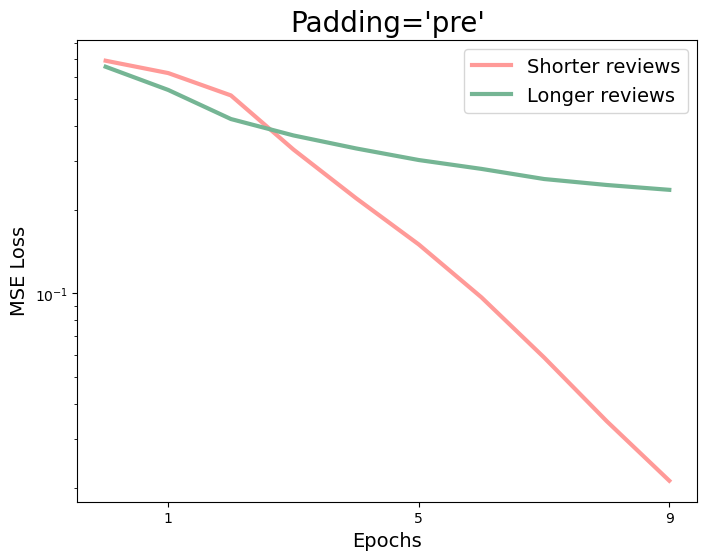

In [76]:
# Helper function to plot the data
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Padding='pre'",fontsize=20)
plt.semilogy(history_short.history['loss'], label='Shorter reviews', color='#FF9A98', linewidth=3)
plt.semilogy(history_long.history['loss'],  label='Longer reviews', color='#75B594', linewidth=3)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs',fontsize=14)
plt.xticks(range(1,epochs,4))
plt.ylabel('MSE Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

### 🍲 Further improvements

We solved the vanishing gradient problem by *pre-padding* the sequences, but what other design choices can help you improve performance?

pre padding: meaningful data is encountered and processed early in the sequence

In [20]:
### edTest(test_chow3) ###
# Submit your answer as a string below
answer3 = '___'